<a href="https://colab.research.google.com/github/nikhilnimbalkar1/Coursera_Capstone/blob/master/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle Of Neighborhoods - Mumbai

# Introduction/Business Problem 

We have data about the areas in Mumbai City, India. Our goal is to cluster venues in Mumbai according to their categories for eg. cafe. book shop, etc. We need to use FourSquare API to retrieve data about these venues from the locations data we have and use K means Clustering to form clusters of these venues and potray them on a map of the city.


# Data

The wikipedia page of the city contains location data with pincodes for the areas in [Mumbai City.](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai)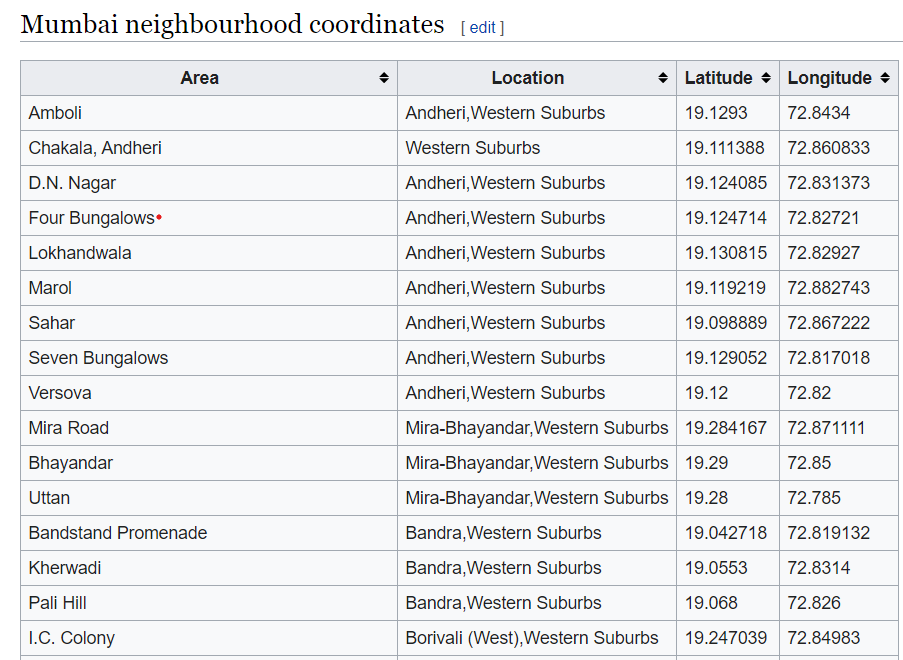

We will use BeautifulSoup library to scrape this data from the webpage, as we can see we already have the coordinates data available as well.

Further we will use FourSquare API to get venues close to the locations we have retrieved from the webpage using the coordinates columns and expand our data for clustering

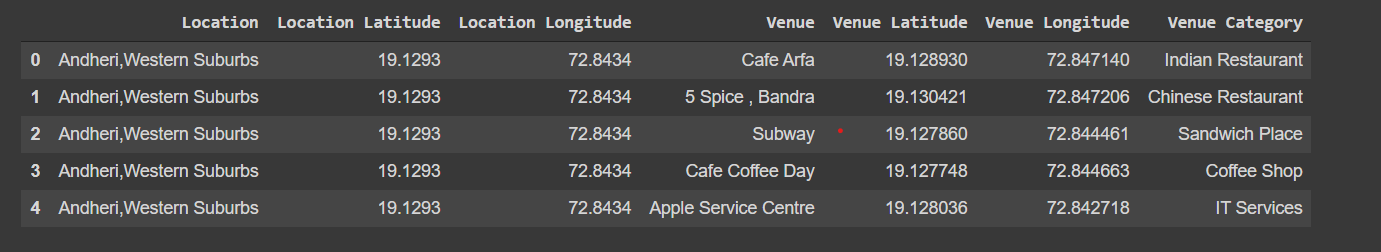

This is the final data that will be used for k means clustering
